# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [5]:
from ddpg_agent import *
from model import *
import torch.optim as optim

# set the random seed and hyperparameters
random_seed = 2
LR_ACTOR = 1e-3         # learning rate of the actor 
# Define the two agents that play tennis
agent_1 = Agent(state_size, action_size, random_seed)
agent_2 = Agent(state_size, action_size, random_seed)

# Define the actor local and target networks
agent_1.actor_local = Actor(state_size, action_size, random_seed).to(device)
agent_1.actor_target = Actor(state_size, action_size, random_seed).to(device)
agent_2.actor_target = Actor(state_size, action_size, random_seed).to(device)
agent_2.actor_local = Actor(state_size, action_size, random_seed).to(device)

# Define a shared replay buffer
agent_1.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

# Agent 1 and 2 share the same actor network and replay buffer
# agent_2.actor_local = agent_1.actor_local
# agent_2.actor_target = agent_1.actor_target
agent_2.memory = agent_1.memory

# Define the optimizers to update weights
agent_1.actor_optimizer = optim.Adam(agent_1.actor_local.parameters(), lr=LR_ACTOR)
agent_2.actor_optimizer = optim.Adam(agent_2.actor_local.parameters(), lr=LR_ACTOR)

Episode 100\Average Score (max over two agents): 0.00 score_1: -0.01 score_2: 0.00
Episode 200\Average Score (max over two agents): 0.00 score_1: 0.00 score_2: -0.01
Episode 300\Average Score (max over two agents): 0.02 score_1: -0.01 score_2: 0.00
Episode 400\Average Score (max over two agents): 0.00 score_1: 0.00 score_2: -0.01
Episode 500\Average Score (max over two agents): 0.02 score_1: -0.01 score_2: 0.00
Episode 600\Average Score (max over two agents): 0.05 score_1: 0.00 score_2: 0.091
Episode 700\Average Score (max over two agents): 0.08 score_1: 0.00 score_2: 0.090
Episode 800\Average Score (max over two agents): 0.06 score_1: 0.10 score_2: -0.01
Episode 900\Average Score (max over two agents): 0.08 score_1: 0.10 score_2: -0.01
Episode 1000\Average Score (max over two agents): 0.07 score_1: 0.40 score_2: 0.29
Episode 1100\Average Score (max over two agents): 0.12 score_1: 0.10 score_2: -0.01
Episode 1183\Average Score (max over two agents): 0.51 score_1: 2.08 score_2: 2.201
En

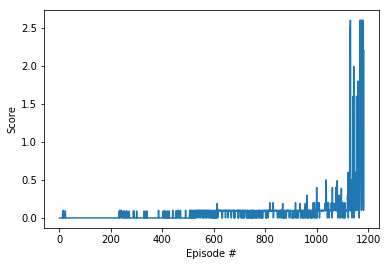

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] 
        state_1 = env_info.vector_observations[0]
        state_2 = env_info.vector_observations[1]
        agent_1.reset()
        agent_2.reset()
        score_1 = 0.
        score_2 = 0.
        for t in range(max_t):
            # Get the actions
            action_1 = agent_1.act(state_1)
            action_2 = agent_2.act(state_2)
            action = np.concatenate([action_1, action_2], axis=1)
            # Get next states from the environment by sending the action
            env_info = env.step(action)[brain_name]          
            next_state_1 = env_info.vector_observations[0]       
            next_state_2 = env_info.vector_observations[1]  
            # Get rewards for the agents
            reward_1 = env_info.rewards[0]                          
            reward_2 = env_info.rewards[1]  
            # Check if the environment is done
            dones = env_info.local_done
            agent_1.step(state_1, action_1, reward_1, next_state_1, dones[0])
            agent_2.step(state_2, action_2, reward_2, next_state_2, dones[1])
            state_1 = next_state_1
            state_2 = next_state_2
            score_1 += reward_1
            score_2 += reward_2
            if np.any(dones):
                break 
        max_score = np.maximum(score_1, score_2)
        scores_deque.append(max_score)
        scores.append(max_score)
        print('\rEpisode {}\Average Score (max over two agents): {:.2f} score_1: {:.2f} score_2: {:.2f}'.format(i_episode, np.mean(scores_deque), score_1, score_2), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\Average Score (max over two agents): {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

scores = ddpg(n_episodes=20000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 